In [599]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx

In [648]:
from itertools import product

def perturb(pos, eps):
    for x,y in pos:
        yield (x + eps*np.random.randn(), y + eps*np.random.randn())
        
def form_graph(rows,cols, eps, r, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    pos = product(range(cols),range(rows))
    
    pos = perturb(pos,eps)
    
    pos = dict(enumerate(pos))
    n = len(pos)
    
    # connect nodes with edges
    G = nx.random_geometric_graph(n,r,pos=pos)
    
    # convert to a Directed graph so that we orient the edges
    G =  nx.DiGraph(G)
    
    # remove the duplicated edges
    for edge in G.edges():
        if edge[0] > edge[1]:
            G.remove_edge(*edge)
    
    # For each edge, give a capacity and current load
    for n1,n2,data in G.edges(data=True):
        data['Capacity'] = np.random.randint(10)+1

    reset_vars(G)
    
    return G


def reset_vars(G):
    for n1,n2,data in G.edges(data=True):
        data['Load'] = 0.0
        
    for n, data in G.nodes(data=True):
        data['Flow'] = 0
        
def edge_data(G, key):
    d = {}
    for n1,n2, data in G.edges(data=True):
        d[(n1,n2)] = data[key]
    return d

def node_data(G, key):
    d = {}
    for n, data in G.nodes(data=True):
        d[n] = data[key]
    return d

## Plotting code
def show(G, labels=False, edge_key='Capacity', size=10):
    pos = node_data(G,'pos')
    
    
    fig = plt.figure(figsize=(size,size))
    #fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.axis('off')
    
    d = edge_data(G,edge_key)
    edges, loads = zip(*d.items())
    
    if min(loads) == 0:
        loads = 1
    else:
        loads = np.abs(np.array(loads))
        loads = 10*loads/max(loads)
    
    nx.draw_networkx(G,pos,ax=ax,edgelist=edges, width=loads, arrows=False)
    
    if labels:
        edge_labels = get_labels(G)
        nx.draw_networkx_edge_labels(G,pos=pos,ax=ax,edge_labels=edge_labels)
        
    plt.title('Edge Width: {}'.format(edge_key), fontsize=20)
    
def get_labels(G):
    labels = {}
    for n1, n2, data in G.edges(data=True):
        labels[(n1,n2)] = '{:.1f} / {}'.format(data['Load'], data['Capacity'])
    return labels
    
    
## CVXPY solving code
def replace_val(G):
    for n, data in G.nodes(data=True):
        data['Flow'] = data['Flow'].value
        
    for _,_,data in G.edges(data=True):
        data['Load'] = data['Load'].value
        
def max_flow(G, oneway=True, perturb=False):
    reset_vars(G)
    constr = []
    obj = 0
    
    for n1,n2,data in G.edges(data=True):
        x = cvx.Variable()
        C = data['Capacity']
        data['Load'] = x
        
        if oneway:
            constr += [0 <= x, x <= C]
        else:
            constr += [-C <= x, x <= C]
            
        G.node[n1]['Flow'] -= x
        G.node[n2]['Flow'] += x
        
        if perturb:
            obj += .01*np.random.rand()*x


    source = min(G.nodes())
    sink = max(G.nodes())

    for n, data in G.nodes(data=True):
        if n == sink:
            obj += G.node[sink]['Flow']

        if n not in (source, sink):
            constr += [G.node[n]['Flow'] == 0]

    prob = cvx.Problem(cvx.Maximize(obj), constr)
    prob.solve()
    replace_val(G)
    
    return G.node[sink]['Flow']

# Max Flow

## Graph
- Directed graph $G = (V,E)$
- Oriented edges: $e = (n_1, n_2)$ "from $n_1$ into $n_2$"
- Flow $f(e)$ can move across edge in **either** direction

## Edges
- Edges have some capacity $C(e) > 0$
- $|f(e)| \leq C(e)$ bounds the flow on each edge
- $f(e) > 0$ on edge $e = (n_1, n_2)$ means positive flow leaves $n_1$ and goes into $n_2$
- $f(e) < 0$ on edge $e = (n_1, n_2)$ means positive flow leaves $n_2$ and goes into $n_1$
- will also refer to as **load** on edge

## Nodes
- source node $S$ can have unlimited flow **out**
- sink node $T$ can have unlimited flow **in**
- all other nodes respect **conservation** of flow: flow in equals flow out

## Goal
- send as much flow from the source to sink as possible while respecting edge capacities and conservation of flow

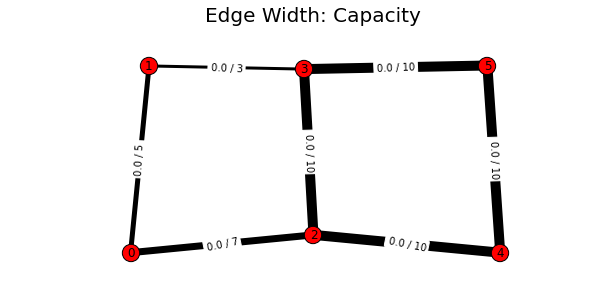

In [652]:
G = form_graph(2,3, .05, 1.2, seed=5)
show(G, labels=True)

# NetworkX
- use Python package `networkx` to represent graphs and store variables
- here `G` is a NetworkX graph with data for:
    - node positions
    - edge capacity and load
    - total flow for a node

In [587]:
G.node

{0: {'Flow': 0, 'pos': (0.022061374344252073, -0.016543507594704382)},
 1: {'Flow': 0, 'pos': (0.121538559350389, 0.9873953935198462)},
 2: {'Flow': 0, 'pos': (1.005480492078909, 0.07912405585307818)},
 3: {'Flow': 0, 'pos': (0.9545383797571879, 0.9704181671034856)},
 4: {'Flow': 0, 'pos': (2.0093801612918516, -0.01649349788896796)},
 5: {'Flow': 0, 'pos': (1.9403617693789097, 0.9897561744706206)}}

In [588]:
G.edge

{0: {1: {'Capacity': 5, 'Load': 0.0}, 2: {'Capacity': 7, 'Load': 0.0}},
 1: {3: {'Capacity': 3, 'Load': 0.0}},
 2: {3: {'Capacity': 10, 'Load': 0.0}, 4: {'Capacity': 10, 'Load': 0.0}},
 3: {5: {'Capacity': 10, 'Load': 0.0}},
 4: {5: {'Capacity': 10, 'Load': 0.0}},
 5: {}}

In [590]:
G.edge[0][1]

{'Capacity': 5, 'Load': 0.0}

In [592]:
G.edges(data=True)

[(0, 1, {'Capacity': 5, 'Load': 0.0}),
 (0, 2, {'Capacity': 7, 'Load': 0.0}),
 (1, 3, {'Capacity': 3, 'Load': 0.0}),
 (2, 3, {'Capacity': 10, 'Load': 0.0}),
 (2, 4, {'Capacity': 10, 'Load': 0.0}),
 (3, 5, {'Capacity': 10, 'Load': 0.0}),
 (4, 5, {'Capacity': 10, 'Load': 0.0})]

In [593]:
G.nodes(data=True)

[(0, {'Flow': 0, 'pos': (0.022061374344252073, -0.016543507594704382)}),
 (1, {'Flow': 0, 'pos': (0.121538559350389, 0.9873953935198462)}),
 (2, {'Flow': 0, 'pos': (1.005480492078909, 0.07912405585307818)}),
 (3, {'Flow': 0, 'pos': (0.9545383797571879, 0.9704181671034856)}),
 (4, {'Flow': 0, 'pos': (2.0093801612918516, -0.01649349788896796)}),
 (5, {'Flow': 0, 'pos': (1.9403617693789097, 0.9897561744706206)})]

# Object-Oriented Convex Optimization
- instead of building up matrices to represent a problem, embed CVXPY variables more naturally in problem structure
- use domain structure (NetworkX graph) to keep track of what variables correspond to what (no translating between arrays and graph edges)

In [653]:
def max_flow(G):
    # Reset load and flow on nodes to zero
    reset_vars(G)
    
    constr = []
    obj = 0
    
    for n1,n2,data in G.edges(data=True):
        
        # Flow on current edge
        x = cvx.Variable()
        data['Load'] = x
        
        # Capacity Constraints
        # Flow in either direction can't exceed capacity
        C = data['Capacity']
        constr += [-C <= x, x <= C]
            
        # Flow on this edge leaves n1 and enters n2 (depending on sign of x)
        G.node[n1]['Flow'] -= x
        G.node[n2]['Flow'] += x
    

    # Set source and sink nodes
    source = min(G.nodes())
    sink = max(G.nodes())

    for n, data in G.nodes(data=True):
        if n == sink:
            # Objective: send as much flow into the sink
            obj += G.node[sink]['Flow']

        if n not in (source, sink):
            # All other nodes must conserve flow
            constr += [G.node[n]['Flow'] == 0]

    prob = cvx.Problem(cvx.Maximize(obj), constr)
    prob.solve()
    replace_val(G)
    
    return G.node[sink]['Flow']

In [654]:
max_flow(G)

9.9999999989809556

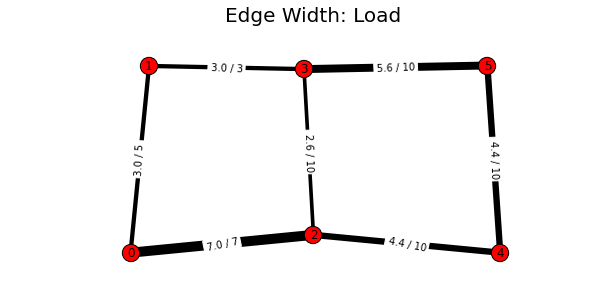

In [655]:
show(G, edge_key='Load', labels=True)

# Larger Example

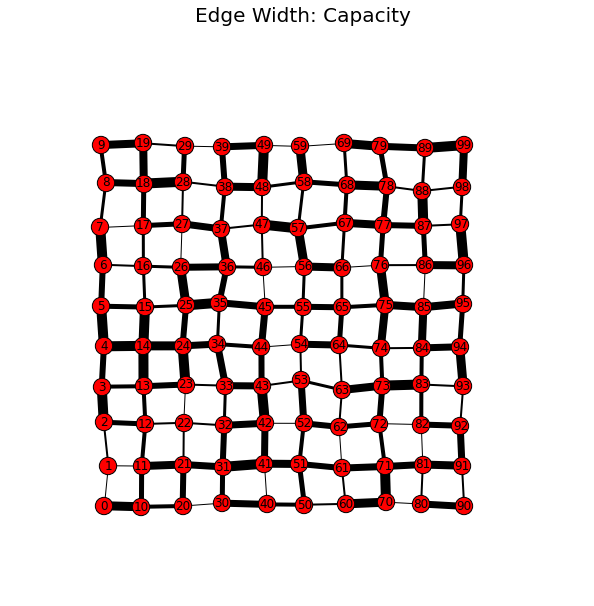

In [658]:
G = form_graph(10,10, .05, 1.2, seed=5)
show(G, labels=False)

9.99999999989


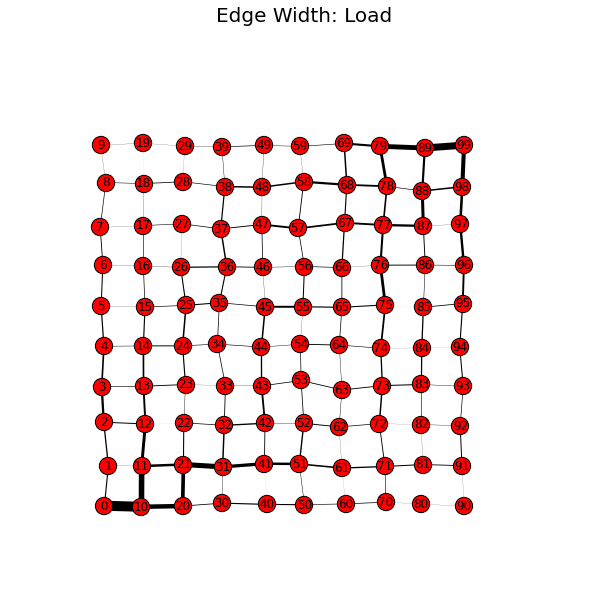

In [657]:
print max_flow(G)
show(G, labels=False, edge_key='Load')

- little bit of flow on many edges
- **many** equally good solutions
- would be nice to get an integral solution
- in fact, such a solution guaranteed to exist with integer capacities
- how to tweak our optimization?

In [660]:
def max_flow(G, perturb=False):
    # Reset load and flow on nodes to zero
    reset_vars(G)
    
    constr = []
    obj = 0
    
    for n1,n2,data in G.edges(data=True):
        
        # Flow on current edge
        x = cvx.Variable()
        data['Load'] = x
        
        # Capacity Constraints
        # Flow in either direction can't exceed capacity
        C = data['Capacity']
        constr += [-C <= x, x <= C]
            
        # Flow on this edge leaves n1 and enters n2 (depending on sign of x)
        G.node[n1]['Flow'] -= x
        G.node[n2]['Flow'] += x
        
        # perturb objective function a bit
        if perturb:
            obj -= .01*np.random.rand()*cvx.abs(x)
    
    # Set source and sink nodes
    source = min(G.nodes())
    sink = max(G.nodes())

    for n, data in G.nodes(data=True):
        if n == sink:
            # Objective: send as much flow into the sink
            obj += G.node[sink]['Flow']

        if n not in (source, sink):
            # All other nodes must conserve flow
            constr += [G.node[n]['Flow'] == 0]

    prob = cvx.Problem(cvx.Maximize(obj), constr)
    prob.solve()
    replace_val(G)
    
    return G.node[sink]['Flow']

- add random perurbation to objective
- likely to move solution to a **vertex** of the polytope of equivalent solutions
- vertex corresponds to sparse solution

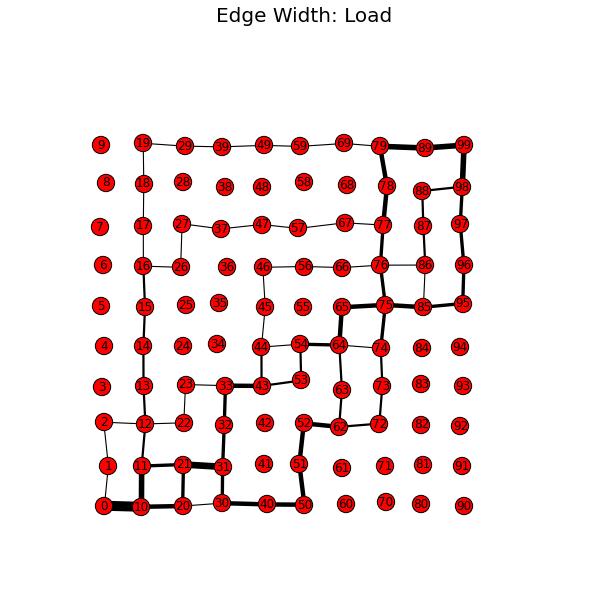

In [661]:
#G = form_graph(10,10, .05, 1.2)
max_flow(G, perturb=True)
show(G, labels=False, edge_key='Load')

# Bipartite Matching
- two sets of nodes, with edges connecting the sets
- people (1-5) and tasks (6-10)
- people can only do a subset of tasks (mapping given by edges)
- each person can only do 1 task
- assign people to tasks to complete as many as possible

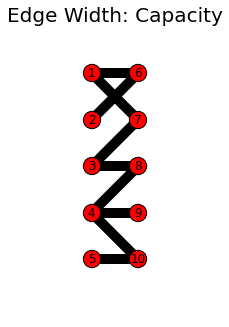

In [662]:
d = {1: (6,7), 2: (6,), 3: (7,8), 4: (8,9,10), 5:(10,)}
G = nx.Graph(d)

for n, data in G.nodes(data=True):
    if n == 0:
        data['pos'] = (0, 3)
    elif n == 11:
        data['pos'] = (3, 3)
    elif n <= 5:
        data['pos'] = (1, 6-n)
    else:
        data['pos'] = (2, (11-n))

for n1,n2, data in G.edges(data=True):
    data['Capacity'] = 1
    data['Load'] = 0

show(G, edge_key='Capacity', labels=False, size=5)

- how to cast as a max flow problem?

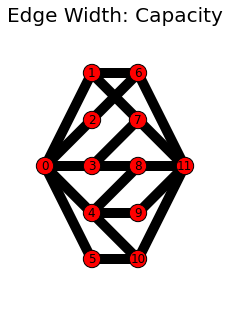

In [663]:
d[0] = (1,2,3,4,5)

for e in (6,7,8,9,10):
    d[e] = (11,)
G = nx.Graph(d)

for n, data in G.nodes(data=True):
    if n == 0:
        data['pos'] = (0, 3)
    elif n == 11:
        data['pos'] = (3, 3)
    elif n <= 5:
        data['pos'] = (1, 6-n)
    else:
        data['pos'] = (2, (11-n))

for n1,n2, data in G.edges(data=True):
    data['Capacity'] = 1
    data['Load'] = 0
    
show(G, edge_key='Capacity', labels=False, size=5)

- add source and sink node
- edges from source to people
- edges from tasks to sink
- all edges have capacity 1
- flow has to be positive
- find max flow

In [664]:
def bipartite(G, perturb=False):
    # Reset load and flow on nodes to zero
    reset_vars(G)
    
    constr = []
    obj = 0
    
    for n1,n2,data in G.edges(data=True):
        
        # Flow on current edge
        x = cvx.Variable()
        data['Load'] = x
        
        # Capacity Constraints
        # Positive flow in direction can't exceed capacity
        C = data['Capacity']
        constr += [0 <= x, x <= C]
            
        # Flow on this edge leaves n1 and enters n2 (depending on sign of x)
        G.node[n1]['Flow'] -= x
        G.node[n2]['Flow'] += x
        
        # perturb objective function a bit
        if perturb:
            obj -= .01*np.random.rand()*cvx.abs(x)
    
    # Set source and sink nodes
    source = min(G.nodes())
    sink = max(G.nodes())

    for n, data in G.nodes(data=True):
        if n == sink:
            # Objective: send as much flow into the sink
            obj += G.node[sink]['Flow']

        if n not in (source, sink):
            # All other nodes must conserve flow
            constr += [G.node[n]['Flow'] == 0]

    prob = cvx.Problem(cvx.Maximize(obj), constr)
    prob.solve()
    replace_val(G)
    
    return G.node[sink]['Flow']

In [667]:
bipartite(G, perturb=False)

4.999999992420709

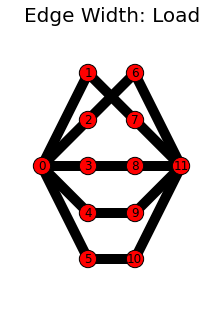

In [668]:
show(G, edge_key='Load', labels=False, size=5)

# Shortest Path
- all edges have equal weight/capacity
- find path connecting source and sink with fewest possible edges

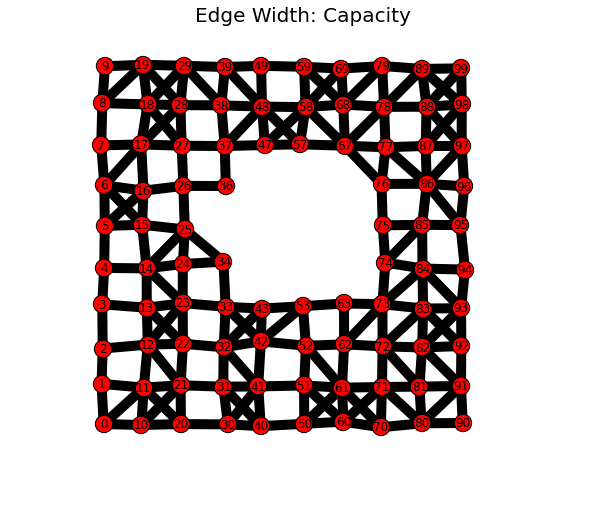

In [672]:
G = form_graph(10,10, .05, 1.4, seed=4)
for n1,n2,data in G.edges(data=True):
    data['Capacity'] = 1
    
for n, data in G.nodes(data=True):
    p = np.array(data['pos'])
    if np.linalg.norm(p - np.array([5,5])) <= 2:
        G.remove_node(n)
    
show(G, edge_key='Capacity', labels=False)

- fix flow into sink at 1
- all edges have capacity 1
- objective: minimize $\sum_{e \in E}|f(e)|$

In [673]:
def shortest_path(G, perturb=False):
    reset_vars(G)
    constr = []
    obj = 0
    
    for n1,n2,data in G.edges(data=True):
        x = cvx.Variable()
        C = data['Capacity']
        data['Load'] = x
        
        constr += [-C <= x, x <= C]
            
        G.node[n1]['Flow'] -= x
        G.node[n2]['Flow'] += x
        
        obj += cvx.abs(x)
        
        if perturb:
            obj += .01*np.random.rand()*x

    source = min(G.nodes())
    sink = max(G.nodes())

    for n, data in G.nodes(data=True):
        if n == sink:
            constr += [G.node[sink]['Flow'] == 1]

        if n not in (source, sink):
            constr += [G.node[n]['Flow'] == 0]

    prob = cvx.Problem(cvx.Minimize(obj), constr)
    prob.solve()
    replace_val(G)
    
    return G.node[sink]['Flow']

In [674]:
shortest_path(G, perturb=True)

1.0000000000000091

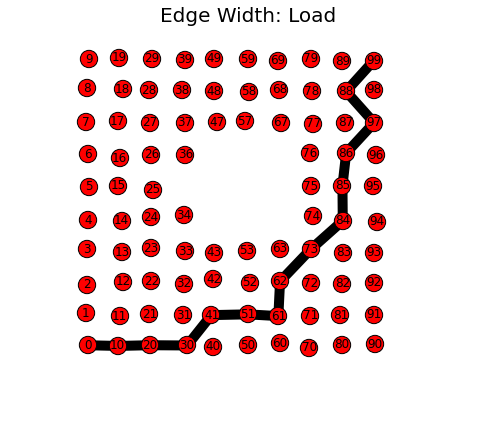

In [676]:
show(G, edge_key='Load', labels=False, size=8)

- without the perturbation trick?

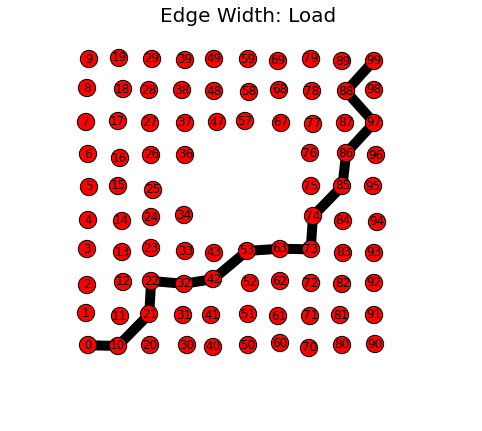

In [682]:
shortest_path(G, perturb=True)
show(G, edge_key='Load', labels=False, size=8)

- easy to generalize this to graph with weights on edges
- find minimum **weight** path

# Min Cost Flow
- fixed amount of flow
- edges have weight, $w(e)$
- **cost** to send flow over edge is $w(e) |f(e)|$
- find flow of minimum cost

In [683]:
for n1,n2,data in G.edges(data=True):
    data['Capacity'] = np.random.randint(10)+1
    data['Cost'] = np.random.rand()

In [692]:
def min_cost_flow(G, k, perturb=False):
    reset_vars(G)
    constr = []
    obj = 0
    
    for n1,n2,data in G.edges(data=True):
        x = cvx.Variable()
        C = data['Capacity']
        data['Load'] = x
        

        constr += [-C <= x, x <= C]
            
        G.node[n1]['Flow'] -= x
        G.node[n2]['Flow'] += x
        
        obj += data['Cost']*cvx.abs(x)
        
        if perturb:
            obj += .01*np.random.rand()*cvx.abs(x)

    source = min(G.nodes())
    sink = max(G.nodes())

    for n, data in G.nodes(data=True):
        if n == sink:
            constr += [G.node[sink]['Flow'] == k]

        if n not in (source, sink):
            constr += [G.node[n]['Flow'] == 0]

    prob = cvx.Problem(cvx.Minimize(obj), constr)
    prob.solve()
    replace_val(G)
    
    return prob.status

In [697]:
min_cost_flow(G, 3, perturb=True)

'optimal'

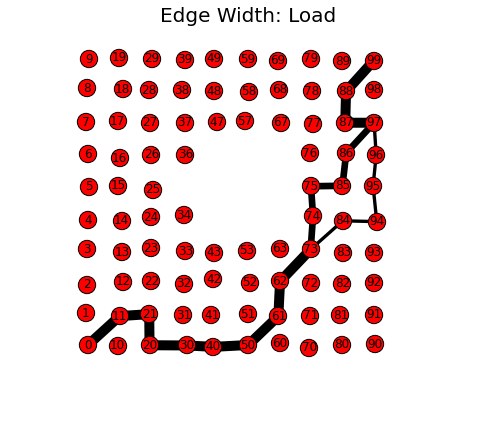

In [698]:
show(G, edge_key='Load', labels=False, size=8)

# Convex cost flow

In [702]:
def cvx_cost_flow(G, k, perturb=False):
    reset_vars(G)
    constr = []
    obj = 0
    
    for n1,n2,data in G.edges(data=True):
        x = cvx.Variable()
        C = data['Capacity']
        data['Load'] = x
        

        constr += [-C <= x, x <= C]
            
        G.node[n1]['Flow'] -= x
        G.node[n2]['Flow'] += x
        
        obj += data['Cost']*cvx.square(x) + 20*cvx.abs(x)
        
        if perturb:
            obj += .01*np.random.rand()*x

    source = min(G.nodes())
    sink = max(G.nodes())

    for n, data in G.nodes(data=True):
        if n == sink:
            constr += [G.node[sink]['Flow'] == k]

        if n not in (source, sink):
            constr += [G.node[n]['Flow'] == 0]

    prob = cvx.Problem(cvx.Minimize(obj), constr)
    prob.solve()
    replace_val(G)
    
    return prob.status

In [703]:
cvx_cost_flow(G, 10, perturb=False)

'optimal'

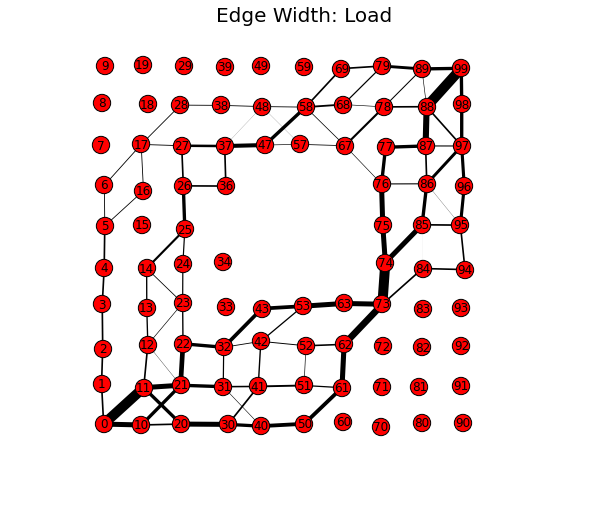

In [704]:
show(G, edge_key='Load', labels=False)

# Extensions
- multicommodity flow: several flows through the network. have to share. how to get everything across, how to trade off between them
- minimum spanning tree
- stable marriage problem